In [1]:
import os
import pandas as pd
import numpy as np
import librosa
import math
import tensorflow as tf
from dataset import load_to_dataframe, turn_into_data_for_model, get_sample_rate
from model import train_cnn 

In [2]:
train_df, test_df = load_to_dataframe('dataset/train', 'dataset/test')
train_data_value, train_data_target, test_data_value, test_data_target = turn_into_data_for_model(
    train_df, test_df, 40, 2048, 512)

Train Size:0
Train Size:300
Train Size:600
Train Size:900
Train Size:1200
Train Size:1500
Train Size:1800
Train Size:2100
Train Size:2400
Train Size:2700
Train Size:3000
Train Size:3300
Train Size:3600
Train Size:3900
Train Size:4200
Train Size:4500
Train Size:4800
Train Size:5100
Train Size:5400
Train Size:5700
Test Size:0
Test Size:300
Test Size:600
Test Size:900
Test Size:1200
(5953, 156, 40)
(1489, 156, 40)


e:\TA-Bill\dataset.py:139: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_data_value = np.asarray(train_data['mfcc'])
e:\TA-Bill\dataset.py:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_data_value = np.asarray(test_data['mfcc'])


In [3]:
np.save("crema_d_f32_train_data_value", train_data_value)
np.save("crema_d_f32_train_data_target", train_data_target)
np.save("crema_d_f32_test_data_value", test_data_value)
np.save("crema_d_f32_test_data_target", test_data_target)

# train_data_value = np.load('saved_dataset/40_2048_512_train_data_value.npy')
# train_data_target = np.load('saved_dataset/40_2048_512_train_data_target.npy')
# test_data_value = np.load('saved_dataset/40_2048_512_test_data_value.npy')
# test_data_target = np.load('saved_dataset/40_2048_512_test_data_target.npy')

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [7]:
base_model = tf.keras.applications.resnet50.ResNet50(
    include_top=True, weights=None, input_shape=(train_data_value.shape[1], train_data_value.shape[2], 1))

In [8]:
base_model.summary(
)

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 156, 40, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 162, 46, 1)   0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 78, 20, 64)   3200        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 78, 20, 64)   256         ['conv1_conv[0][0]']      

In [11]:
resnet_model = tf.keras.Sequential()
base_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False, weights=None, input_shape=(train_data_value.shape[1], train_data_value.shape[2], 1))
# for layer in base_model.layers:
#     layer.trainable = False
resnet_model.add(base_model)
resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(1024, activation='relu'))
resnet_model.add(tf.keras.layers.Dropout(0.3))
resnet_model.add(tf.keras.layers.Dense(6, activation="softmax"))
resnet_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 2, 2048)        23581440  
                                                                 
 flatten_2 (Flatten)         (None, 20480)             0         
                                                                 
 dense_4 (Dense)             (None, 1024)              20972544  
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 6)                 6150      
                                                                 
Total params: 44,560,134
Trainable params: 44,507,014
Non-trainable params: 53,120
_________________________________________________________________


In [12]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
resnet_model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
resnet_history = resnet_model.fit(train_data_value, train_data_target, validation_data=(
    test_data_value, test_data_target), batch_size=32, epochs=20)

Epoch 1/20
187/187 [==============================] - 37s 163ms/step - loss: 5.8938 - accuracy: 0.2795 - val_loss: 1.6016 - val_accuracy: 0.2995
Epoch 2/20
187/187 [==============================] - 29s 158ms/step - loss: 1.5474 - accuracy: 0.3501 - val_loss: 1.6009 - val_accuracy: 0.3277
Epoch 3/20
187/187 [==============================] - 29s 157ms/step - loss: 1.5194 - accuracy: 0.3854 - val_loss: 1.5238 - val_accuracy: 0.3694
Epoch 4/20
187/187 [==============================] - 30s 159ms/step - loss: 1.4555 - accuracy: 0.4208 - val_loss: 1.4238 - val_accuracy: 0.4171
Epoch 5/20
187/187 [==============================] - 30s 158ms/step - loss: 1.4520 - accuracy: 0.4173 - val_loss: 1.4145 - val_accuracy: 0.4540
Epoch 6/20
187/187 [==============================] - 30s 159ms/step - loss: 1.4348 - accuracy: 0.4292 - val_loss: 1.6656 - val_accuracy: 0.3224
Epoch 7/20
187/187 [==============================] - 29s 157ms/step - loss: 1.3824 - accuracy: 0.4571 - val_loss: 1.3151 - val_ac

In [16]:
resnet_history = resnet_model.fit(train_data_value, train_data_target, validation_data=(
    test_data_value, test_data_target), batch_size=64, epochs=20)

Epoch 1/20
187/187 [==============================] - 29s 156ms/step - loss: 1.2603 - accuracy: 0.4979 - val_loss: 1.5322 - val_accuracy: 0.4238
Epoch 2/20
187/187 [==============================] - 29s 156ms/step - loss: 1.2283 - accuracy: 0.5130 - val_loss: 1.3211 - val_accuracy: 0.4681
Epoch 3/20
187/187 [==============================] - 29s 156ms/step - loss: 1.2303 - accuracy: 0.5139 - val_loss: 2.9873 - val_accuracy: 0.3741
Epoch 4/20
187/187 [==============================] - 29s 156ms/step - loss: 1.2337 - accuracy: 0.5186 - val_loss: 1.3687 - val_accuracy: 0.4708
Epoch 5/20
187/187 [==============================] - 29s 156ms/step - loss: 1.2613 - accuracy: 0.5083 - val_loss: 1.6462 - val_accuracy: 0.3674
Epoch 6/20
187/187 [==============================] - 29s 156ms/step - loss: 1.3106 - accuracy: 0.4866 - val_loss: 1.9762 - val_accuracy: 0.1719
Epoch 7/20
187/187 [==============================] - 29s 157ms/step - loss: 1.4312 - accuracy: 0.4292 - val_loss: 1.8307 - val_ac

In [30]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
resnet_model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
resnet_history2 = resnet_model.fit(train_data_value, train_data_target, validation_data=(
    test_data_value, test_data_target), batch_size=32, epochs=20)

Epoch 1/20
187/187 [==============================] - 16s 66ms/step - loss: 1.7902 - accuracy: 0.1700 - val_loss: 1.7902 - val_accuracy: 0.1706
Epoch 2/20
187/187 [==============================] - 11s 60ms/step - loss: 1.7902 - accuracy: 0.1643 - val_loss: 1.7902 - val_accuracy: 0.1706
Epoch 3/20
187/187 [==============================] - 11s 59ms/step - loss: 1.7902 - accuracy: 0.1708 - val_loss: 1.7902 - val_accuracy: 0.1706
Epoch 4/20
187/187 [==============================] - 11s 57ms/step - loss: 1.7902 - accuracy: 0.1708 - val_loss: 1.7902 - val_accuracy: 0.1706
Epoch 5/20
187/187 [==============================] - 11s 59ms/step - loss: 1.7902 - accuracy: 0.1708 - val_loss: 1.7902 - val_accuracy: 0.1706
Epoch 6/20
187/187 [==============================] - 11s 59ms/step - loss: 1.7902 - accuracy: 0.1708 - val_loss: 1.7902 - val_accuracy: 0.1706
Epoch 7/20
187/187 [==============================] - 11s 59ms/step - loss: 1.7902 - accuracy: 0.1708 - val_loss: 1.7902 - val_accuracy:

In [32]:
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(
    train_data_value.shape[1], train_data_value.shape[2], 1)))
cnn_model.add(tf.keras.layers.MaxPooling2D(
    (3, 3), strides=(2, 2), padding='same'))
cnn_model.add(tf.keras.layers.BatchNormalization())

# 2nd conv layer
cnn_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D(
    (3, 3), strides=(2, 2), padding='same'))
cnn_model.add(tf.keras.layers.BatchNormalization())

# 3rd conv layer
cnn_model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D(
    (2, 2), strides=(2, 2), padding='same'))
cnn_model.add(tf.keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(64, activation='relu'))
cnn_model.add(tf.keras.layers.Dropout(0.3))

cnn_model.add(tf.keras.layers.Dense(6, activation='softmax'))
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
cnn_model.summary()
cnn_model.compile(optimizer=optimiser,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
history = cnn_model.fit(train_data_value, train_data_target, validation_data=(
    test_data_value, test_data_target), batch_size=32, epochs=20)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 154, 38, 128)      1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 77, 19, 128)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 77, 19, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 17, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 9, 64)        0         
 2D)                                                             
                                                      

In [35]:
cnn_model2 = tf.keras.Sequential()
cnn_model2.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(
    train_data_value.shape[1], train_data_value.shape[2], 1)))
cnn_model2.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model2.add(tf.keras.layers.MaxPooling2D(
    (3, 3), strides=(2, 2), padding='same'))
cnn_model2.add(tf.keras.layers.BatchNormalization())

# 2nd conv layer
cnn_model2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model2.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model2.add(tf.keras.layers.MaxPooling2D(
    (3, 3), strides=(2, 2), padding='same'))
cnn_model2.add(tf.keras.layers.BatchNormalization())

# 3rd conv layer
cnn_model2.add(tf.keras.layers.Conv2D(32, (2, 2), activation='relu'))
cnn_model2.add(tf.keras.layers.Conv2D(32, (2, 2), activation='relu'))
cnn_model2.add(tf.keras.layers.Conv2D(32, (2, 2), activation='relu'))
cnn_model2.add(tf.keras.layers.MaxPooling2D(
    (2, 2), strides=(2, 2), padding='same'))
cnn_model2.add(tf.keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
cnn_model2.add(tf.keras.layers.Flatten())
cnn_model2.add(tf.keras.layers.Dense(64, activation='relu'))
cnn_model2.add(tf.keras.layers.Dropout(0.3))

cnn_model2.add(tf.keras.layers.Dense(6, activation='softmax'))
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
cnn_model2.summary()
cnn_model2.compile(optimizer=optimiser,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
cnn_history2 = cnn_model2.fit(train_data_value, train_data_target, validation_data=(
    test_data_value, test_data_target), batch_size=32, epochs=20)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 154, 38, 128)      1280      
                                                                 
 conv2d_4 (Conv2D)           (None, 152, 36, 128)      147584    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 76, 18, 128)      0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 76, 18, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 74, 16, 64)        73792     
                                                                 
 conv2d_6 (Conv2D)           (None, 72, 14, 64)       

In [36]:
cnn_model3 = tf.keras.Sequential()
cnn_model3.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(
    train_data_value.shape[1], train_data_value.shape[2], 1)))
cnn_model3.add(tf.keras.layers.MaxPooling2D(
    (3, 3), strides=(2, 2), padding='same'))
cnn_model3.add(tf.keras.layers.BatchNormalization())

# 2nd conv layer
cnn_model3.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model3.add(tf.keras.layers.MaxPooling2D(
    (3, 3), strides=(2, 2), padding='same'))
cnn_model3.add(tf.keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
cnn_model3.add(tf.keras.layers.Flatten())
cnn_model3.add(tf.keras.layers.Dense(64, activation='relu'))
cnn_model3.add(tf.keras.layers.Dropout(0.3))

cnn_model3.add(tf.keras.layers.Dense(6, activation='softmax'))
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
cnn_model3.summary()
cnn_model3.compile(optimizer=optimiser,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
cnn_history3 = cnn_model3.fit(train_data_value, train_data_target, validation_data=(
    test_data_value, test_data_target), batch_size=32, epochs=20)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 154, 38, 128)      1280      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 77, 19, 128)      0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 77, 19, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_12 (Conv2D)          (None, 75, 17, 64)        73792     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 38, 9, 64)        0         
 2D)                                                             
                                                      

In [6]:
base_weighted_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False, weights='imagenet', input_shape=(train_data_value.shape[1], train_data_value.shape[2], 3))

In [19]:
print(train_data_value[1])

[[   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 ...
 [-453  113   30 ...   -5   -2   -4]
 [-456  114   36 ...   -6   -4   -7]
 [-462  117   34 ...   -4   -2   -4]]


In [28]:
train_data_value.shape

(5953, 156, 40)

In [4]:
train_data_value_reshaped2 = np.zeros((5953, 156, 40, 3))
train_data_value_reshaped2[..., 0] = train_data_value
train_data_value_reshaped2[..., 1] = train_data_value
train_data_value_reshaped2[..., 2] = train_data_value
test_data_value_reshaped2 = np.zeros((test_data_value.shape[0], 156, 40, 3))
test_data_value_reshaped2[..., 0] = test_data_value
test_data_value_reshaped2[..., 1] = test_data_value
test_data_value_reshaped2[..., 2] = test_data_value

In [21]:
train_data_value_reshaped = np.repeat(train_data_value, 3, axis=-1)

In [26]:
test_data_value_reshaped = np.repeat(test_data_value, 3, axis=-1)


(5953, 156, 40)

In [7]:
resnet_model_imagenet = tf.keras.Sequential()
for layer in base_weighted_model.layers:
    layer.trainable = False
resnet_model_imagenet.add(base_weighted_model)
resnet_model_imagenet.add(tf.keras.layers.Flatten())
resnet_model_imagenet.add(tf.keras.layers.Dense(1024, activation='relu'))
resnet_model_imagenet.add(tf.keras.layers.Dropout(0.3))
resnet_model_imagenet.add(tf.keras.layers.Dense(6, activation="softmax"))
resnet_model_imagenet.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 2, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 1024)              20972544  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 6)                 6150      
                                                                 
Total params: 44,566,406
Trainable params: 20,978,694
Non-trainable params: 23,587,712
_________________________________________________________________


In [8]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
resnet_model_imagenet.compile(optimizer=optimiser,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
resnet_history_weighted = resnet_model_imagenet.fit(train_data_value_reshaped2, train_data_target, validation_data=(
    test_data_value_reshaped2, test_data_target), batch_size=64, epochs=50)

Epoch 1/50
94/94 [==============================] - 15s 102ms/step - loss: 2.3183 - accuracy: 0.3775 - val_loss: 1.4482 - val_accuracy: 0.4157
Epoch 2/50
94/94 [==============================] - 8s 82ms/step - loss: 1.3533 - accuracy: 0.4621 - val_loss: 1.4310 - val_accuracy: 0.3909
Epoch 3/50
94/94 [==============================] - 8s 81ms/step - loss: 1.2731 - accuracy: 0.5058 - val_loss: 1.3051 - val_accuracy: 0.4829
Epoch 4/50
94/94 [==============================] - 8s 81ms/step - loss: 1.2472 - accuracy: 0.4991 - val_loss: 1.2745 - val_accuracy: 0.4889
Epoch 5/50
94/94 [==============================] - 8s 81ms/step - loss: 1.1696 - accuracy: 0.5392 - val_loss: 1.2726 - val_accuracy: 0.5104
Epoch 6/50
94/94 [==============================] - 8s 82ms/step - loss: 1.1458 - accuracy: 0.5503 - val_loss: 1.2698 - val_accuracy: 0.5044
Epoch 7/50
94/94 [==============================] - 8s 81ms/step - loss: 1.0988 - accuracy: 0.5737 - val_loss: 1.2778 - val_accuracy: 0.4923
Epoch 8/50


In [19]:
test_loss, test_acc = resnet_model_imagenet.evaluate(test_data_value_reshaped2, test_data_target)
y_true = []
y_pred = []

print(test_loss)
print(test_acc)

for x,y in zip(test_data_value_reshaped2, test_data_target):
    y_true.extend(tf.argmax(y))
    y_pred.extend(tf.argmax(resnet_model_imagenet.predict(x)))

    
# for x, y in test_data_value_reshaped2:
#     y_true.extend(tf.argmax(y, axis=1))
#     y_pred.extend(tf.argmax(resnet_model_imagenet.predict(x), axis=1))

# cm = tf.math.confusion_matrix(y_true, y_pred)

# print('Confusion Matrix:')
# print(cm)

47/47 [==============================] - 2s 46ms/step - loss: 1.8000 - accuracy: 0.4795
1.7999998331069946
0.4795164465904236


InvalidArgumentError: Expected dimension in the range [0, 0), but got 1 [Op:ArgMax]

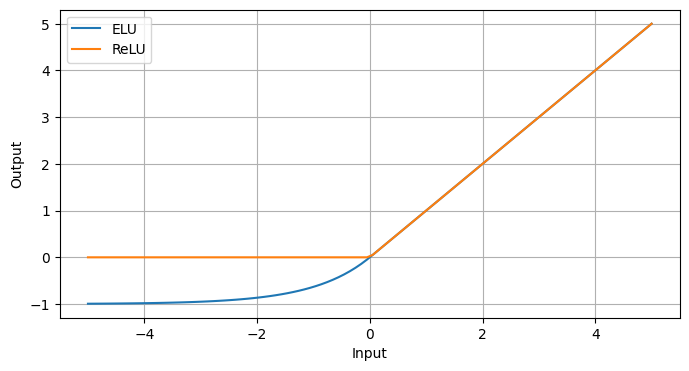

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Define the ELU and ReLU activation functions
def elu(x, alpha=1.0):
    return np.where(x >= 0, x, alpha * (np.exp(x) - 1))

def relu(x):
    return np.maximum(0, x)

# Generate some sample data
x = np.linspace(-5, 5, 100)

# Compute the output of the ELU and ReLU activation functions
y_elu = elu(x)
y_relu = relu(x)

# Plot the results
# plt.subplot(figsize=(4))
fig = plt.figure(figsize=(8,4))
plt.plot(x, y_elu, label='ELU')
plt.plot(x, y_relu, label='ReLU')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.grid()
plt.show()

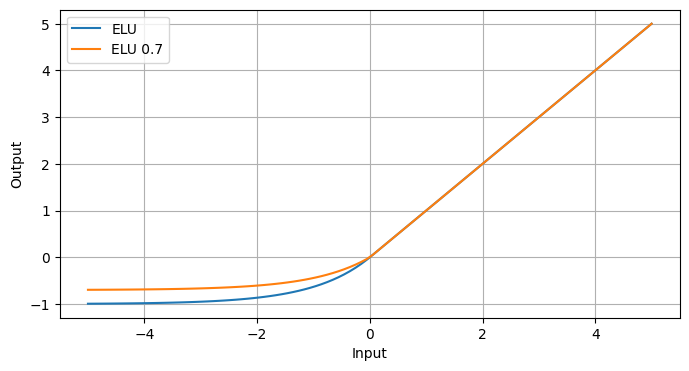

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Define the ELU and ReLU activation functions
def elu(x, alpha=1.0):
    return np.where(x >= 0, x, alpha * (np.exp(x) - 1))

def relu(x):
    return np.maximum(0, x)

# Generate some sample data
x = np.linspace(-5, 5, 100)

# Compute the output of the ELU and ReLU activation functions
y_elu = elu(x)
y_relu = elu(x, 0.7)

# Plot the results
# plt.subplot(figsize=(4))
fig = plt.figure(figsize=(8,4))
plt.plot(x, y_elu, label='ELU')
plt.plot(x, y_relu, label='ELU 0.7')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.grid()
plt.show()